<a href="https://colab.research.google.com/github/Stonepia/Scipy-Lec/blob/master/2_5_Sparse_Matrices_in_SciPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* sparse matrix is a matrix, which is* almost empty*
* storing all the zeros is wasteful -> store only nonzero items
* think **compression**
* pros: huge memory savings
* cons: depends on actual storage scheme, (\*) usually does not hold

# Storage Schemes


- seven sparse matrix types in scipy.sparse:
>1. csc_matrix: Compressed Sparse Column format
>2. csr_matrix: Compressed Sparse Row format
>3. bsr_matrix: Block Sparse Row format
>4. lil_matrix: List of Lists format
>5. dok_matrix: Dictionary of Keys format
>6. coo_matrix: COOrdinate format (aka IJV, triplet format)
>7. dia_matrix: DIAgonal format


- each suitable for some tasks

- many employ sparsetools C++ module by Nathan Bell

passing a sparse matrix object to NumPy functions expecting ndarray/matrix does **not** work

In [0]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

## Common Methods

* all scipy.sparse classes are subclasses of spmatrix
> * default implementation of arithmetic operations
> > *   always converts to CSR
> > * subclasses override for efficiency
> * shape, data type set/get
> * nonzero indices
> * format conversion, interaction with NumPy (toarray(), todense())
> * …
* attributes:
> * mtx.A - same as mtx.toarray()
> * mtx.T - transpose (same as mtx.transpose())
> * mtx.H - Hermitian (conjugate) transpose
> * mtx.real - real part of complex matrix
> * mtx.imag - imaginary part of complex matrix
> * mtx.size - the number of nonzeros (same as self.getnnz())
> * mtx.shape - the number of rows and columns (tuple)
* data usually stored in NumPy arrays

## Sparse Matrix Classes

### [Diagnoal  Format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_matrix.html)

* very simple scheme
* diagonals in dense NumPy array of shape `(n_diag, length)`
> * fixed length -> waste space a bit when far from main diagonal
> * subclass of `_data_matrix` (sparse matrix classes with `.data` attribute)
* offset for each diagonal
> * 0 is the main diagonal
> * negative offset = below
> * positive offset = above
> * Subdiagnoals are "left aligned" , and the super diagonals are"right aligned". Specifically, the mappint between the `data` and the sparse matrix `A` is `data[i,j] == A[j - offsets[i], j]`

* fast matrix * vector (sparsetools)
* fast and easy item-wise operations
> * manipulate data array directly (fast NumPy machinery)
* constructor accepts:
> * dense matrix (array)
> * sparse matrix
> * shape tuple (create empty matrix)
> * (`data, offsets`) tuple
* no slicing, no individual item access
* use:
> * rather specialized
> * solving PDEs by finite differences
> * with an iterative solver

In [0]:
data = np.array([[1,2,3,4]]).repeat(3, axis=0)
print(data)
offsets = np.array([0,-1,2])
mtx = sparse.dia_matrix((data, offsets), shape=(4,4))
mtx

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]


<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements (3 diagonals) in DIAgonal format>

In [0]:
mtx.todense()

matrix([[1, 0, 3, 0],
        [1, 2, 0, 4],
        [0, 2, 3, 0],
        [0, 0, 3, 4]])

In [0]:
vec = np.ones((4,))
mtx*vec

array([4., 7., 5., 7.])

In [0]:
print(mtx.toarray() * vec)

[[1. 0. 3. 0.]
 [1. 2. 0. 4.]
 [0. 2. 3. 0.]
 [0. 0. 3. 4.]]


In [0]:
N = 5
data = np.ones((3, 5))
offsets = np.array([0,-1,1])
A = sps.dia_matrix((data, offsets), shape=(N, N), dtype=float)
A.A

array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.]])

### [Lists of LIsts Format (LIL)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)

* row-based linked list
> * each row is a Python list (sorted) of column indices of **non-zero** elements
> * rows stored in a NumPy array (`dtype=np.object`)
> * non-zero values data stored analogously
* efficient for constructing sparse matrices incrementally
* constructor accepts:
> * dense matrix (array)
> * sparse matrix
> * shape tuple (create empty matrix)
* flexible slicing, changing sparsity structure is efficient
* slow arithmetics, slow column slicing due to being row-based
* use:
> * when sparsity pattern is not known apriori or changes
> * example: reading a sparse matrix from a text file
* inserting a single item can take linear time in the worst case; to construct a matrix efficiently, make sure the items are pre-sorted by index, per row.

In [0]:
from numpy.random import rand

mtx = sparse.lil_matrix((4, 5))
data = np.round(rand(2,3))
print(data)

# assign the data using fancy indexing:
mtx[:2, [1,2,3]] = data
mtx

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1. 1. 0.]
 [1. 1. 1.]]


<4x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in LInked List format>

In [0]:
mtx.todense()

matrix([[0., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [0]:
# More Slicing and indexing:
mtx = sparse.lil_matrix([[0, 1, 2, 0], [3, 0, 1, 0], [1, 0, 0, 1]])
mtx.todense()

matrix([[0, 1, 2, 0],
        [3, 0, 1, 0],
        [1, 0, 0, 1]], dtype=int64)

In [0]:
mtx[:2,:]

<2x4 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in LInked List format>

In [0]:
mtx[:2,:].todense()

matrix([[0, 1, 2, 0],
        [3, 0, 1, 0]], dtype=int64)

In [0]:
%timeit mtx[1:2,[0,2]].todense()

10000 loops, best of 3: 109 µs per loop


### [Dictionary of Keys Format (DOK)](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.dok_matrix.html)

* subclass of Python dict
> * keys are `(row, column)` index tuples (no duplicate entries allowed)
> * values are corresponding non-zero values
* efficient for constructing sparse matrices incrementally
* constructor accepts:
> * dense matrix (array)
> * sparse matrix
> * shape tuple (create empty matrix)
* efficient O(1) access to individual elements
* flexible slicing, changing sparsity structure is efficient
* can be efficiently converted to a coo_matrix once constructed
* slow arithmetics (`for` loops with `dict.iteritems()`)
* use:
> * when sparsity pattern is not known apriori or changes

In [0]:
mtx = sparse.dok_matrix((5,5), dtype=np.float64)
mtx

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Dictionary Of Keys format>

In [0]:
for ir in range(5):
  for ic in range(5):
    mtx[ir,ic] = 1.0 * (ir !=ic)

mtx.todense()

matrix([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.]])

In [0]:
mtx[1,[1,3]].todense()

matrix([[0., 1.]])

### [Coordinate Format (COO)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html)
* also known as the ‘ijv’ or ‘triplet’ format
> * three NumPy arrays: row, col, data
`data[i]` is value at `(row[i], col[i])` position
> * permits duplicate entries
> * subclass of `_data_matrix `(sparse matrix classes with `.data` attribute)
* fast format for constructing sparse matrices
* constructor accepts:
> * dense matrix (array)
> * sparse matrix
> * shape tuple (create empty matrix)
> * `(data, (i,j))` tuple
* very fast conversion to and from CSR/CSC formats
* fast matrix * vector (sparsetools)
* fast and easy item-wise operations
> * manipulate data array directly (fast NumPy machinery)
* no slicing, no arithmetics (directly)
* use:
> * facilitates fast conversion among sparse formats
> * when converting to other format (usually CSR or CSC), duplicate entries are summed together
> > * facilitates efficient construction of finite element matrices

In [0]:
row = np.array([0, 3, 1, 0])
col = np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])
mtx = sparse.coo_matrix((data, (row, col)), shape=(4, 4))
mtx.todense()

matrix([[4, 0, 9, 0],
        [0, 7, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 5]])

duplicates entries are summed together:

In [0]:
row = np.array([0, 0, 1, 3, 1, 0, 0])
col = np.array([0, 2, 1, 3, 1, 0, 0])
data = np.array([1, 1, 1, 1, 1, 1, 1])
mtx = sparse.coo_matrix((data, (row, col)), shape=(4, 4))
mtx.todense()

matrix([[3, 0, 1, 0],
        [0, 2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]])

No slicing:

In [0]:
mtx[2, 3]

TypeError: ignored

### [Compressed Sparse Row Format (CSR)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)

* row oriented
> * three NumPy arrays: `indices, indptr, data`
> > * `indices` is array of column indices
> > * `data` is array of corresponding nonzero values
> > * `indptr` points to row starts in `indices` and `data`
> > * length is n_row + 1, last item = number of values = length of both indices and data
> > * nonzero values of the i-th row are `data[indptr[i]:indptr[i+1]]` with column indices `indices[indptr[i]:indptr[i+1]]`
> > * ` item (i, j)` can be accessed as `data[indptr[i]+k]`, where `k` is position of `j` in `indices[indptr[i]:indptr[i+1]]`
> * subclass of `_cs_matrix `(common CSR/CSC functionality)
> >  * subclass of `_data_matrix` (sparse matrix classes with .data attribute)
* fast matrix vector products and other arithmetics (sparsetools)
* constructor accepts:
> * dense matrix (array)
> * sparse matrix
> * shape tuple (create empty matrix)
> * `(data, ij)` tuple
> * `(data, indices, indptr)` tuple
* efficient row slicing, row-oriented operations
* slow column slicing, expensive changes to the sparsity structure
* use:
> * actual computations (most linear solvers support this format)

In [0]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
mtx = sparse.csr_matrix((data, (row, col)), shape=(3, 3))

print(mtx.todense())
print(mtx.data)
print(mtx.indices)
print(mtx.indptr)

[[1 0 2]
 [0 0 3]
 [4 5 6]]
[1 2 3 4 5 6]
[0 2 2 0 1 2]
[0 2 3 6]


the indices for row i are stored in `indices[indptr[i]:indptr[i+1]] ` , and their correspoding values are stored in `data[indptr[i]:indptr[i+1]]`. 

So , for row 0, the indices are stored in `indices[indptr[0]: indptr[1]]`, that is in `indices[0:2]`, so we get 0 and 2. the data is 1 and 2.
For row 1, the indices stored in `indices[2:3]`, get 2, the data is 3.

As an example of how to construct a CSR matrix incrementally, the following snippet builds a term-document matrix from texts:

In [0]:
docs = [["hello", "world", "hello"], ["goodbye", "cruel", "world"]]
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in docs:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

sparse.csr_matrix((data, indices, indptr), dtype=int).toarray()

array([[2, 1, 0, 0],
       [0, 1, 1, 1]])

###  [Compressed Sparse Column Format (CSC)](https://scipy-lectures.org/advanced/scipy_sparse/csc_matrix.html)


* length is n_row + 1, last item = number of values = length of both indices and data
* nonzero values of the i-th row are `data[indptr[i]:indptr[i+1]]` with column indices `indices[indptr[i]:indptr[i+1]]`
* ` item (i, j)` can be accessed as `data[indptr[i]+k]`, where `k` is position of `j` in `indices[indptr[i]:indptr[i+1]]`

* efficient column slicing, column-oriented operations
* slow row slicing, expensive changes to the sparsity structure

The operations is same as CSR

### [Block Compressed Row Format (BSR)](https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.sparse.bsr_matrix.html#scipy.sparse.bsr_matrix)

* basically a CSR with dense sub-matrices of fixed shape instead of scalar items

> * block size `(R, C)` must evenly divide the shape of the `matrix (M, N)`
> * three NumPy arrays:` indices, indptr, data`
> > * `indices` is array of column indices for each block
> > * `data` is array of corresponding nonzero values of `shape (nnz, R, C)`
> > * …
> * subclass of `_cs_matrix` (common CSR/CSC functionality)
> > * subclass of `_data_matrix` (sparse matrix classes with `.data` attribute)
* fast matrix vector products and other arithmetics (sparsetools)

* constructor accepts:
> * dense matrix (array)
> * sparse matrix
> * shape tuple (create empty matrix)
> * `(data, ij`) tuple
> * `(data, indices, indptr)` tuple
* many arithmetic operations considerably more efficient than CSR for sparse matrices with dense sub-matrices

* use:
> * like CSR
> * vector-valued finite element discretizations

In [0]:
mtx = sparse.bsr_matrix((3, 4), dtype=np.int8)
mtx

<3x4 sparse matrix of type '<class 'numpy.int8'>'
	with 0 stored elements (blocksize = 1x1) in Block Sparse Row format>

In [0]:
mtx = sparse.bsr_matrix((3, 4), blocksize=(3, 2), dtype=np.int8)
mtx

<3x4 sparse matrix of type '<class 'numpy.int8'>'
	with 0 stored elements (blocksize = 3x2) in Block Sparse Row format>

In [0]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
mtx = sparse.bsr_matrix((data, (row, col)), shape=(3, 3))
mtx  

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements (blocksize = 1x1) in Block Sparse Row format>

In [0]:
mtx.todense()

matrix([[1, 0, 2],
        [0, 0, 3],
        [4, 5, 6]], dtype=int64)

In [0]:
indptr = np.array([0, 2, 3, 6])
indices = np.array([0, 2, 2, 0, 1, 2])
#data = np.array([1, 2, 3, 4, 5, 6]).repeat(4).reshape(6, 2, 2)
data = np.around(np.random.rand(6*4)*100).reshape(6,2,2)
mtx = sparse.bsr_matrix((data, indices, indptr))
mtx.todense()

matrix([[22., 89.,  0.,  0., 94., 87.],
        [67.,  0.,  0.,  0., 82., 38.],
        [ 0.,  0.,  0.,  0., 96., 24.],
        [ 0.,  0.,  0.,  0., 11., 16.],
        [66., 77., 90., 54., 56.,  3.],
        [60., 89., 78., 28.,  8., 72.]])

In [0]:
print(mtx.indices)
print(mtx.indptr)
print(data)

[0 2 2 0 1 2]
[0 2 3 6]
[[[93. 76.]
  [49. 43.]]

 [[86. 42.]
  [30. 79.]]

 [[85. 37.]
  [59. 76.]]

 [[ 9. 82.]
  [14. 76.]]

 [[51. 41.]
  [79.  9.]]

 [[ 0.  0.]
  [97. 94.]]]


In [0]:
mtx.data

array([[[22., 89.],
        [67.,  0.]],

       [[94., 87.],
        [82., 38.]],

       [[96., 24.],
        [11., 16.]],

       [[66., 77.],
        [60., 89.]],

       [[90., 54.],
        [78., 28.]],

       [[56.,  3.],
        [ 8., 72.]]])

In [0]:
# BSR does not support indexing
mtx[0,0]

NotImplementedError: ignored

## Summary



>format	| matrix \* vector |	get item	| fancy get |	set item |	fancy set |	solvers |	note
>--- | --- |  --- |  --- |  --- |  --- | --- | ---
>DIA | sparsetools  | 	. | 	. | 	. | 	. | 	iterative | has data array, specialized
> LIL	 | via CSR	 | yes	 | yes | 	yes	 | yes | 	iterative | 	arithmetics via CSR, incremental construction
>DOK | 	python | 	yes	 | one axis only	 | yes	 | yes	 | iterative | 	O(1) item access, incremental construction
>COO	 | sparsetools | 	. | 	. | 	. | 	.	 | iterative | 	has data array, facilitates fast conversion
>CSR	 | sparsetools | 	yes | 	yes	 | slow | 	.	 | any	 | has data array, fast row-wise ops
>CSC | 	sparsetools	 | yes | 	yes | 	slow	 | . | 	any	 | has data array, fast column-wise ops
>BSR | 	sparsetools	 | . | 	.	 | .	 | .	 | specialized | 	has data array, specialized

# Linear System Solvers

* sparse matrix/eigenvalue problem solvers live in [scipy.sparse.linalg](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#module-scipy.sparse.linalg)

* the submodules:
> * `dsolve`: direct factorization methods for solving linear systems
> * `isolve`: iterative methods for solving linear systems
> * `eigen`: sparse eigenvalue problem solvers

In [0]:
import scipy.sparse.linalg as spla
# spla.__all__

## Sparse Direct Solvers

* default solver: SuperLU 4.0
> * included in SciPy
> * real and complex systems
> * both single and double precision
* optional: umfpack
> * real and complex systems
> * double precision only
> * recommended for performance
> * wrappers now live in `scikits.umfpack`
> * check-out the new `scikits.suitesparse` by Nathaniel Smith

import the whole module, and see its docstring:

In [0]:
from scipy.sparse.linalg import dsolve
help(dsolve)

both superlu and umfpack can be used (if the latter is installed) as follows:

In [0]:
import numpy as np
from scipy import sparse

In [0]:
mtx = sparse.spdiags([[1, 2, 3, 4, 5], [6, 5, 8, 9, 10]], [0, 1], 5, 5)
mtx.todense()
rhs = np.array([1, 2, 3, 4, 5], dtype=np.float32)

* solve as single precision real:

In [0]:
mtx1 = mtx.astype(np.float32)
x = dsolve.spsolve(mtx1, rhs, use_umfpack=False)
print(x)
print("Error: %s" % (mtx1 * x - rhs))  


[106.  -21.    5.5  -1.5   1. ]
Error: [0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


* solve as double precision real:

In [0]:
mtx2 = mtx.astype(np.float64)
x = dsolve.spsolve(mtx2, rhs, use_umfpack=True)
print(x)  

print("Error: %s" % (mtx2 * x - rhs))

[106.  -21.    5.5  -1.5   1. ]
Error: [0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


* solve as single precision complex:

In [0]:
mtx1 = mtx.astype(np.complex64)
x = dsolve.spsolve(mtx1, rhs, use_umfpack=False)
print(x)  

print("Error: %s" % (mtx1 * x - rhs))

[106. +0.j -21. +0.j   5.5+0.j  -1.5+0.j   1. +0.j]
Error: [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


* solve as double precision complex:

In [0]:
mtx2 = mtx.astype(np.complex128)
x = dsolve.spsolve(mtx2, rhs, use_umfpack=True)
print(x)

print("Error: %s" % (mtx2 * x - rhs)) 

[106. +0.j -21. +0.j   5.5+0.j  -1.5+0.j   1. +0.j]
Error: [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


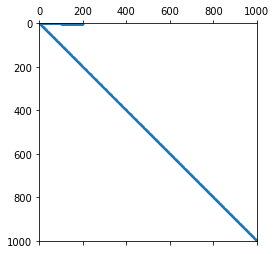

rezidual: 2.6838142380927864e-14


In [0]:
"""
Solve a linear system
=======================

Construct a 1000x1000 lil_matrix and add some values to it, convert it
to CSR format and solve A x = b for x:and solve a linear system with a
direct solver.
"""
import numpy as np
import scipy.sparse as sps
from matplotlib import pyplot as plt
from scipy.sparse.linalg.dsolve import linsolve

rand = np.random.rand

mtx = sps.lil_matrix((1000, 1000), dtype=np.float64)
mtx[0, :100] = rand(100)
mtx[1, 100:200] = mtx[0, :100]
mtx.setdiag(rand(1000))

plt.clf()
plt.spy(mtx, marker='.', markersize=2)
plt.show()

mtx = mtx.tocsr()
rhs = rand(1000)

x = linsolve.spsolve(mtx, rhs)

print('rezidual: %r' % np.linalg.norm(mtx * x - rhs))

## Iterative Solvers

* the isolve module contains the following solvers:
> * `bicg` (BIConjugate Gradient)
> * `bicgstab` (BIConjugate Gradient STABilized)
> * `cg` (Conjugate Gradient) - symmetric positive definite matrices only
> * `cgs` (Conjugate Gradient Squared)
> * `gmres` (Generalized Minimal RESidual)
> * `minres` (MINimum RESidual)
> * `qmr` (Quasi-Minimal Residual)

In [1]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
def mv(v):
    return np.array([2*v[0], 3*v[1]])

A = LinearOperator((2, 2), matvec=mv)
A

A.matvec(np.ones(2))

A * np.ones(2)

array([2., 3.])

## Eigenvalue Problem Solvers